# IndiaAI Face Deduplication – Quick Duplicate Mining

Run the optional install cell below if you're on a fresh environment, then
execute the final cell to scan a folder of face images (LFW deep-funneled by
default) for the strongest duplicate candidates and visualise them side by
side with similarity scores.


In [67]:
# Optional: install dependencies for a fresh environment
# Remove or skip this cell if requirements are already satisfied.
!pip install -r requirements_indiaai.txt



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Configure and Run Duplicate Search

Adjust the configuration block (dataset path, similarity metric, thresholds,
limits, and output location) before executing the cell. The script automatically
handles the nested `lfw-deepfunneled/lfw-deepfunneled` layout shipped with the
LFW deep-funneled archive.


Loading face encodings from /home/snipl/Documents/Prototypes/IndiaAI/IndiaAI_De-Duplication/lfw_dataset/lfw-deepfunneled/lfw-deepfunneled ...


Loaded 500 faces from /home/snipl/Documents/Prototypes/IndiaAI/IndiaAI_De-Duplication/lfw_dataset/lfw-deepfunneled/lfw-deepfunneled

Displaying 12 duplicate candidates (metric=euclidean, threshold=0.6)
#01 Andrew_Caldecott/Andrew_Caldecott_0001.jpg <-> Andrew_Gilligan/Andrew_Gilligan_0001.jpg | euclidean = 0.2082


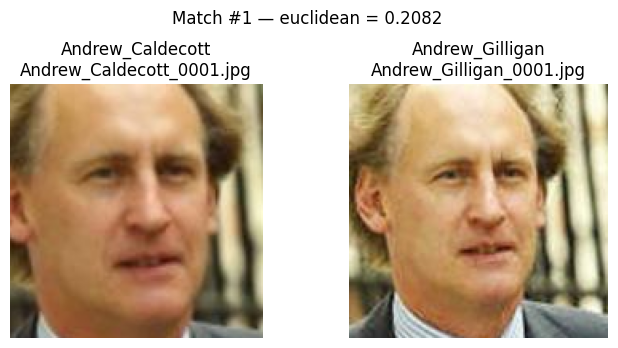

#02 Abdullah_Gul/Abdullah_Gul_0002.jpg <-> Abdullah_Gul/Abdullah_Gul_0004.jpg | euclidean = 0.2250


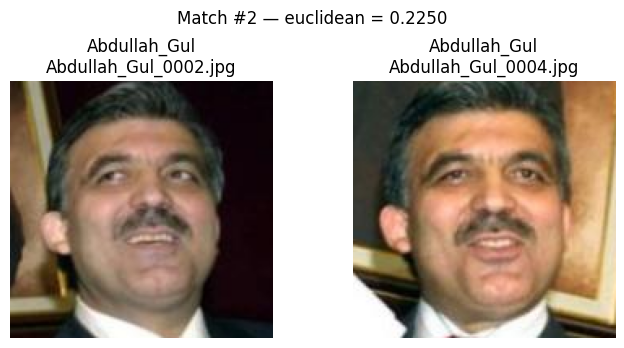

#03 Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg <-> Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0002.jpg | euclidean = 0.2290


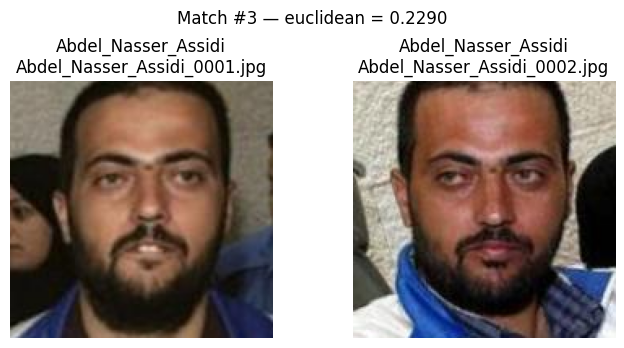

#04 Akhmed_Zakayev/Akhmed_Zakayev_0001.jpg <-> Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg | euclidean = 0.2385


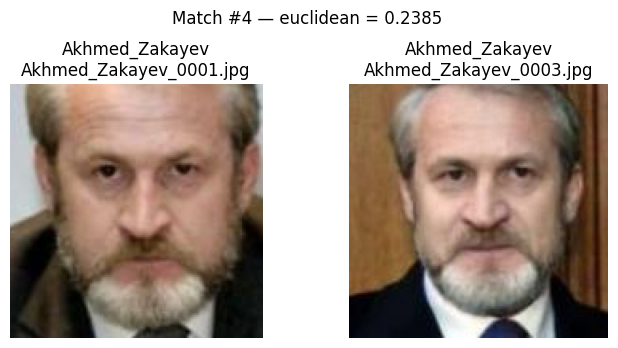

#05 Abel_Pacheco/Abel_Pacheco_0002.jpg <-> Abel_Pacheco/Abel_Pacheco_0003.jpg | euclidean = 0.2466


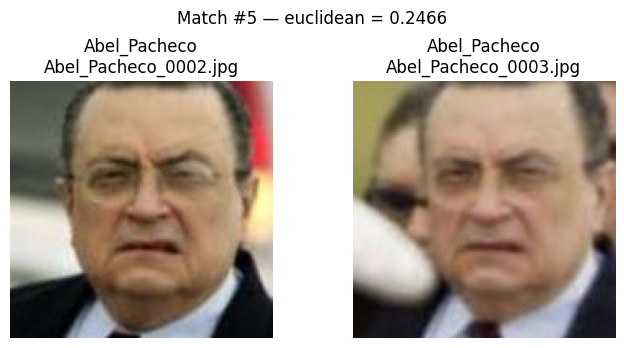

#06 Alice_Fisher/Alice_Fisher_0001.jpg <-> Alice_Fisher/Alice_Fisher_0002.jpg | euclidean = 0.2559


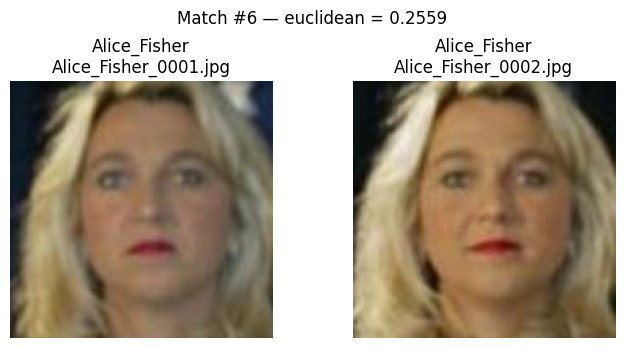

#07 Ai_Sugiyama/Ai_Sugiyama_0002.jpg <-> Ai_Sugiyama/Ai_Sugiyama_0003.jpg | euclidean = 0.2581


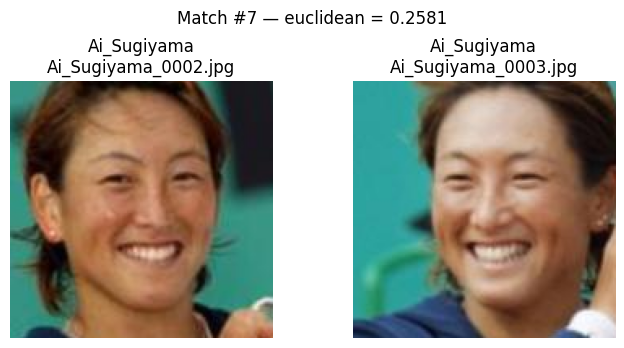

#08 Abdullah_Gul/Abdullah_Gul_0003.jpg <-> Abdullah_Gul/Abdullah_Gul_0004.jpg | euclidean = 0.2706


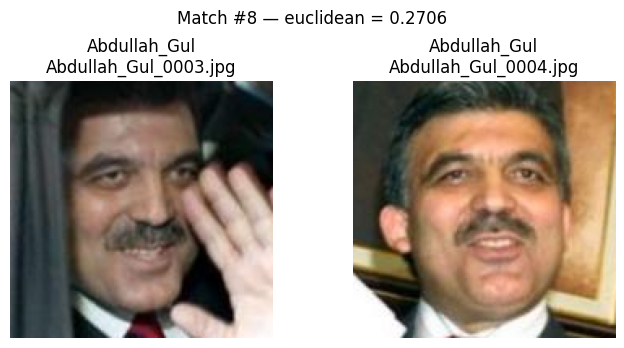

#09 Amram_Mitzna/Amram_Mitzna_0001.jpg <-> Amram_Mitzna/Amram_Mitzna_0002.jpg | euclidean = 0.2755


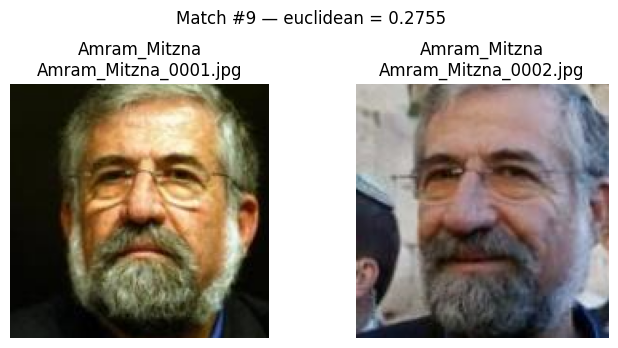

#10 Alan_Ball/Alan_Ball_0001.jpg <-> Alan_Ball/Alan_Ball_0002.jpg | euclidean = 0.2817


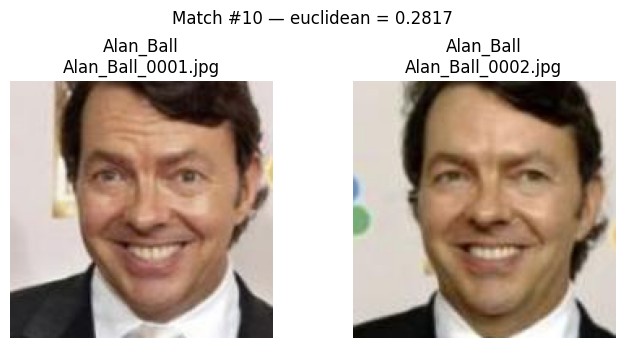

#11 Ai_Sugiyama/Ai_Sugiyama_0001.jpg <-> Ai_Sugiyama/Ai_Sugiyama_0002.jpg | euclidean = 0.2826


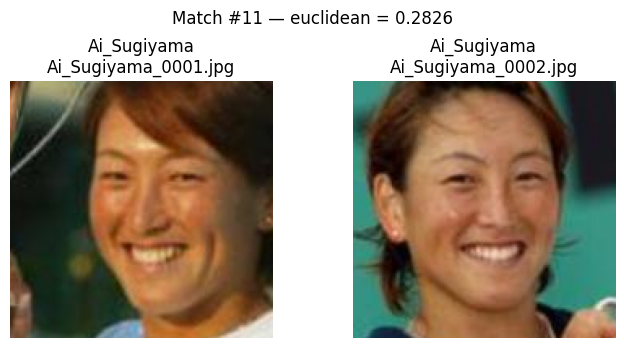

#12 Ai_Sugiyama/Ai_Sugiyama_0001.jpg <-> Ai_Sugiyama/Ai_Sugiyama_0003.jpg | euclidean = 0.2944


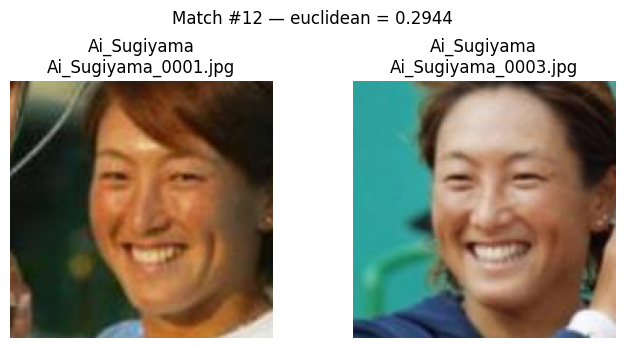

In [68]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple

import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

try:
    import face_recognition
except ImportError as exc:  # pragma: no cover - user-facing error
    raise ImportError(
        "face_recognition is required for duplicate detection. Install it via `pip install face_recognition`."
    ) from exc


@dataclass
class FaceRecord:
    person_id: str
    image_path: Path
    face_location: Tuple[int, int, int, int]
    encoding: np.ndarray


def resolve_dataset_path(dataset_root: Path | str) -> Path:
    """Return the directory that actually contains the face images."""
    path = Path(dataset_root).expanduser().resolve()
    deepfunneled = path / "lfw-deepfunneled"
    nested = deepfunneled / "lfw-deepfunneled"
    if nested.is_dir():
        return nested
    if deepfunneled.is_dir():
        return deepfunneled
    return path


def load_face_records(
    dataset_root: Path | str,
    limit_per_identity: Optional[int] = None,
    max_total_images: Optional[int] = None,
) -> List[FaceRecord]:
    """Load images, detect faces, and compute encodings for the dataset."""
    image_root = resolve_dataset_path(dataset_root)
    records: List[FaceRecord] = []
    processed = 0

    for person_dir in sorted(image_root.iterdir()):
        if not person_dir.is_dir():
            continue
        count_for_person = 0
        for image_path in sorted(person_dir.glob("*.jpg")):
            try:
                image = face_recognition.load_image_file(image_path)
                locations = face_recognition.face_locations(image, model="hog")
                if not locations:
                    continue
                encodings = face_recognition.face_encodings(image, locations, num_jitters=1)
                for loc, enc in zip(locations, encodings):
                    records.append(
                        FaceRecord(
                            person_id=person_dir.name,
                            image_path=Path(image_path),
                            face_location=loc,
                            encoding=enc.astype(np.float32),
                        )
                    )
                    count_for_person += 1
                    processed += 1
                    if max_total_images and processed >= max_total_images:
                        return records
                if limit_per_identity and count_for_person >= limit_per_identity:
                    break
            except Exception as exc:  # pragma: no cover - best-effort loading
                print(f"[WARN] Failed to process {image_path}: {exc}")
                continue
        if max_total_images and processed >= max_total_images:
            break
    return records


def compute_pair_scores(records: List[FaceRecord], metric: str = "euclidean") -> List[Tuple[int, int, float]]:
    if len(records) < 2:
        return []

    encodings = np.vstack([r.encoding for r in records])

    if metric == "euclidean":
        pairs: List[Tuple[int, int, float]] = []
        for i in range(len(records) - 1):
            diff = encodings[i + 1 :] - encodings[i]
            dists = np.linalg.norm(diff, axis=1)
            for j, score in enumerate(dists, start=i + 1):
                pairs.append((i, j, float(score)))
        return pairs
    if metric == "cosine":
        norms = np.linalg.norm(encodings, axis=1, keepdims=True)
        norms[norms == 0.0] = 1.0
        normalized = encodings / norms
        sim_matrix = normalized @ normalized.T
        return [
            (i, j, float(sim_matrix[i, j]))
            for i in range(len(records) - 1)
            for j in range(i + 1, len(records))
        ]
    raise ValueError("metric must be 'euclidean' or 'cosine'")


def find_duplicate_pairs(
    records: List[FaceRecord],
    threshold: float,
    metric: str,
    top_k: int,
) -> List[Tuple[FaceRecord, FaceRecord, float]]:
    pairs = compute_pair_scores(records, metric=metric)
    if not pairs:
        return []

    if metric == "euclidean":
        filtered = [(records[i], records[j], score) for i, j, score in pairs if score <= threshold]
        filtered.sort(key=lambda item: item[2])
    else:
        filtered = [(records[i], records[j], score) for i, j, score in pairs if score >= threshold]
        filtered.sort(key=lambda item: item[2], reverse=True)

    if not filtered:
        reverse = metric != "euclidean"
        sorted_pairs = sorted(pairs, key=lambda item: item[2], reverse=reverse)
        filtered = [(records[i], records[j], score) for i, j, score in sorted_pairs[:top_k]]
        print(f"No pairs satisfied the threshold; showing top {len(filtered)} closest pairs instead.")

    return filtered[:top_k]


def crop_face(record: FaceRecord, padding: float = 0.25) -> Image.Image:
    image = Image.open(record.image_path).convert("RGB")
    top, right, bottom, left = record.face_location
    height = bottom - top
    width = right - left
    pad_h = int(height * padding)
    pad_w = int(width * padding)
    left = max(0, left - pad_w)
    top = max(0, top - pad_h)
    right = min(image.width, right + pad_w)
    bottom = min(image.height, bottom + pad_h)
    return image.crop((left, top, right, bottom))


def plot_duplicate_pair(
    record_a: FaceRecord,
    record_b: FaceRecord,
    score: float,
    metric: str,
    index: int,
    save_dir: Optional[str] = None,
    show: bool = True,
) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
    axes[0].imshow(crop_face(record_a))
    axes[0].axis("off")
    axes[0].set_title(f"{record_a.person_id}\n{record_a.image_path.name}")

    axes[1].imshow(crop_face(record_b))
    axes[1].axis("off")
    axes[1].set_title(f"{record_b.person_id}\n{record_b.image_path.name}")

    fig.suptitle(f"Match #{index} — {metric} = {score:.4f}")
    fig.tight_layout()

    if save_dir:
        output_dir = Path(save_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        out_path = output_dir / f"match_{index:02d}_{record_a.person_id}_{record_b.person_id}.png"
        fig.savefig(out_path, dpi=150, bbox_inches="tight")
        print(f"Saved visualization to {out_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)


# --- Configuration ---
IMAGE_FOLDER = Path("lfw_dataset")  # dataset root; adjust if stored elsewhere
THRESHOLD = 0.6
METRIC = "euclidean"  # or "cosine"
TOP_K = 12
MAX_IMAGES_PER_IDENTITY = 5  # limit per identity so the demo runs faster
MAX_TOTAL_IMAGES = 500       # safety cap for very large datasets
SAVE_DIR = None              # e.g. Path("./dedup_matches") to persist figures
SHOW_PLOTS = True

resolved_root = resolve_dataset_path(IMAGE_FOLDER)
print(f"Loading face encodings from {resolved_root} ...")
face_records = load_face_records(
    resolved_root,
    limit_per_identity=MAX_IMAGES_PER_IDENTITY,
    max_total_images=MAX_TOTAL_IMAGES,
)
print(f"Loaded {len(face_records)} faces from {resolved_root}")

if not face_records:
    raise RuntimeError(
        "No faces were encoded. Check the dataset path and ensure `face_recognition` finds faces."
    )

matches = find_duplicate_pairs(face_records, threshold=THRESHOLD, metric=METRIC, top_k=TOP_K)

if not matches:
    print("\nNo candidate duplicates to display. Try relaxing the threshold or increasing the image limits.")
else:
    print(f"\nDisplaying {len(matches)} duplicate candidates (metric={METRIC}, threshold={THRESHOLD})")
    for idx, (record_a, record_b, score) in enumerate(matches, start=1):
        print(
            f"#{idx:02d} {record_a.person_id}/{record_a.image_path.name} <-> "
            f"{record_b.person_id}/{record_b.image_path.name} | {METRIC} = {score:.4f}"
        )
        plot_duplicate_pair(
            record_a,
            record_b,
            score,
            metric=METRIC,
            index=idx,
            save_dir=SAVE_DIR,
            show=SHOW_PLOTS,
        )
